# Unsupervised Learning & Association Rule Mining Mini Project -1 (k-means clustering with Silhouette score)
---
**Name: Varsha.S**

**BITS ID: 2024AIML516**

---

### Import all necessary libraries

In [3]:
# ==============================================================
# SECTION 1: IMPORTS
# ==============================================================

# -------------------- Data Handling & Numerical Operations --------------------
import numpy as np                  # Fundamental package for numerical computations
import pandas as pd                 # For handling datasets in DataFrame format

# -------------------- Visualization --------------------
import matplotlib.pyplot as plt     # For creating plots like scatter, line, bar charts
import seaborn as sns               # High-level interface for attractive statistical plots

# -------------------- Data Preprocessing --------------------
from sklearn.preprocessing import MinMaxScaler  # For scaling/normalizing features to a range (e.g., 0-1)

# -------------------- Clustering & Evaluation --------------------
from sklearn.cluster import KMeans         # K-Means clustering algorithm
from sklearn.metrics import silhouette_score  # To evaluate clustering quality (how well clusters are separated)
from sklearn.decomposition import PCA      # Principal Component Analysis for dimensionality reduction or visualization

# -------------------- Warnings & Display Settings --------------------
import warnings
warnings.filterwarnings('ignore')         # Ignore unnecessary warnings during code execution

# Display settings for Pandas DataFrames
pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Format floats to 3 decimal places


### Data preprocessing

In [5]:
# ==============================================================
# SECTION 2: LOAD AND INSPECT DATA
# ==============================================================

# Load the dataset
# Note: Replace the filename with the correct path if needed
df = pd.read_csv('cricketers.csv', sep='\t')

# Display first few rows to verify correct loading
print("First 5 rows of the dataset:")
display(df.head())

# Display basic info to understand data structure and types
print("\nDataset Information:")
print(df.info())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Shape of the dataset (rows, columns)
print("\nDataset shape:", df.shape)

# Display column names for reference
print("\nColumns in dataset:")
# Strip any leading/trailing whitespace from column names
df.columns = df.columns.str.strip()
print(df.columns.tolist())


First 5 rows of the dataset:


,PLAYER,matches_played,innings_batted,runs_scored,highest_runs,balls_faced,average_runs,strike_rate,innings_bowled,overs,runs_given,wickets_obtained,average_runs_per_wicket,bowling_economy
0,Aaron Finch,10,9,134,46,100,16.750,144.000,0,0.000,0,0,0.000,0.000
1,AB de Villiers,12,11,480,90,275,53.330,174.540,0,0.000,0,0,0.000,0.000
2,Abhishek Sharma,3,3,63,46,33,63.000,190.900,0,0.000,0,0,0.000,0.000
3,Ajinkya Rahane,15,14,370,65,313,28.460,118.210,0,0.000,0,0,0.000,0.000
4,Alex Hales,6,6,148,45,118,24.660,125.420,0,0.000,0,0,0.000,0.000



Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   PLAYER                    109 non-null    object 
 1   matches_played            109 non-null    int64  
 2   innings_batted            109 non-null    int64  
 3   runs_scored               109 non-null    int64  
 4   highest_runs              109 non-null    int64  
 5   balls_faced               109 non-null    int64  
 6   average_runs              109 non-null    float64
 7   strike_rate               109 non-null    float64
 8   innings_bowled            109 non-null    int64  
 9   overs                     109 non-null    float64
 10  runs_given                109 non-null    int64  
 11  wickets_obtained          109 non-null    int64  
 12  average_runs_per_wicket   109 non-null    float64
 13  bowling_economy           109 non-null    f

### Data Normalization

In [7]:
# ==============================================================
# SECTION 3: DATA NORMALIZATION
# ==============================================================

# Create a copy of the dataframe (excluding player names for normalization)
df_numeric = df.drop(columns=['PLAYER'])

# Initialize the MinMaxScaler to scale values between 0 and 1
scaler = MinMaxScaler()

# Fit and transform the numeric data
df_scaled = scaler.fit_transform(df_numeric)

# Convert the scaled data back to a DataFrame with original column names
df_normalized = pd.DataFrame(df_scaled, columns=df_numeric.columns)

# Concatenate the PLAYER column back to the normalized data for reference
df_normalized = pd.concat([df['PLAYER'], df_normalized], axis=1)

# Display first few rows of normalized dataset
print("First 5 rows of the normalized dataset:")
display(df_normalized.head())


First 5 rows of the normalized dataset:


,PLAYER,matches_played,innings_batted,runs_scored,highest_runs,balls_faced,average_runs,strike_rate,innings_bowled,overs,runs_given,wickets_obtained,average_runs_per_wicket,bowling_economy
0,Aaron Finch,0.588,0.529,0.182,0.359,0.194,0.221,0.480,0.000,0.000,0.000,0.000,0.000,0.000
1,AB de Villiers,0.706,0.647,0.653,0.703,0.533,0.703,0.582,0.000,0.000,0.000,0.000,0.000,0.000
2,Abhishek Sharma,0.176,0.176,0.086,0.359,0.064,0.831,0.636,0.000,0.000,0.000,0.000,0.000,0.000
3,Ajinkya Rahane,0.882,0.824,0.503,0.508,0.607,0.375,0.394,0.000,0.000,0.000,0.000,0.000,0.000
4,Alex Hales,0.353,0.353,0.201,0.352,0.229,0.325,0.418,0.000,0.000,0.000,0.000,0.000,0.000


### Identifying All Rounders
#### a. Identify the all-rounder by the following logic -> Get the players with most runs whose wickets are more than the median wickets of all the players where the players must have taken atleast 1 wicket 

In [9]:
# ==============================================================
# SECTION 4: IDENTIFYING ALL-ROUNDERS (Question a)
# ==============================================================

# -------------------- Task (a): Identify All-Rounders --------------------

# Step 1: Consider only players who have taken at least 1 wicket
bowlers = df[df['wickets_obtained'] > 0]

# Step 2: Calculate the median wickets among these players
median_wickets = bowlers['wickets_obtained'].median()
print(f"Median wickets among players with at least 1 wicket: {median_wickets}")

# Step 3: Filter players whose wickets are greater than the median
potential_all_rounders = bowlers[bowlers['wickets_obtained'] > median_wickets]

# Step 4: Among them, find players with the most runs scored
all_rounders = potential_all_rounders.sort_values(by='runs_scored', ascending=False)

# Step 5: Display the top all-rounders
print("Top All-Rounders based on runs scored and wickets obtained:\n")
display(all_rounders[['PLAYER', 'runs_scored', 'wickets_obtained']].head(10))


Median wickets among players with at least 1 wicket: 7.0
Top All-Rounders based on runs scored and wickets obtained:



,PLAYER,runs_scored,wickets_obtained
89,Sunil 0rine,357,17
6,Andre Russell,316,13
33,Hardik Pandya,260,18
79,Shakib Al Hasan,239,14
47,Kru0l Pandya,228,12
10,Ben Stokes,196,8
27,Dwayne Bravo,141,14
46,Krish0ppa Gowtham,126,11
70,Ravichandran Ashwin,102,10
71,Ravindra Jadeja,89,11


### K-means clustering and Silhoutte Score
#### b. Perform K-means clustering for different values of K (2,3,4,5) and evaluate the quality of clustering using the Silhouette score.

In [11]:
# ==============================================================
# SECTION 5: K-MEANS CLUSTERING AND SILHOUETTE SCORE (Question b)
# ==============================================================

# -------------------- Task (b): K-Means Clustering with Silhouette Score --------------------

# Select relevant normalized features for clustering
features = ['runs_scored', 'average_runs', 'strike_rate', 'wickets_obtained', 'bowling_economy']
X = df_normalized[features].values

# Define list of K values to test
k_values = [2, 3, 4, 5]
silhouette_scores = []

# Perform K-Means clustering for each K and compute silhouette scores
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    
    # Compute silhouette score
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    
    print(f"K = {k}, Silhouette Score = {score:.3f}")

# Store results in a DataFrame for visualization
silhouette_df = pd.DataFrame({'K': k_values, 'Silhouette Score': silhouette_scores})

# Display the silhouette scores
print("\nSilhouette Scores Summary:")
display(silhouette_df)


K = 2, Silhouette Score = 0.438
K = 3, Silhouette Score = 0.413
K = 4, Silhouette Score = 0.369
K = 5, Silhouette Score = 0.402

Silhouette Scores Summary:


,K,Silhouette Score
0,2,0.438
1,3,0.413
2,4,0.369
3,5,0.402


### PCA Visualization and Cluster Plots
#### c. For each value of K, plot clusters (all cluster points in the same cluster with the same color, cluster points in different clusters in different colors).  Use PCA for dimensionality reduction so that the data points can be plotted in 2 - D. Take only 5 data points from each cluster and the point should be labelled with the player name, else 0 marks.

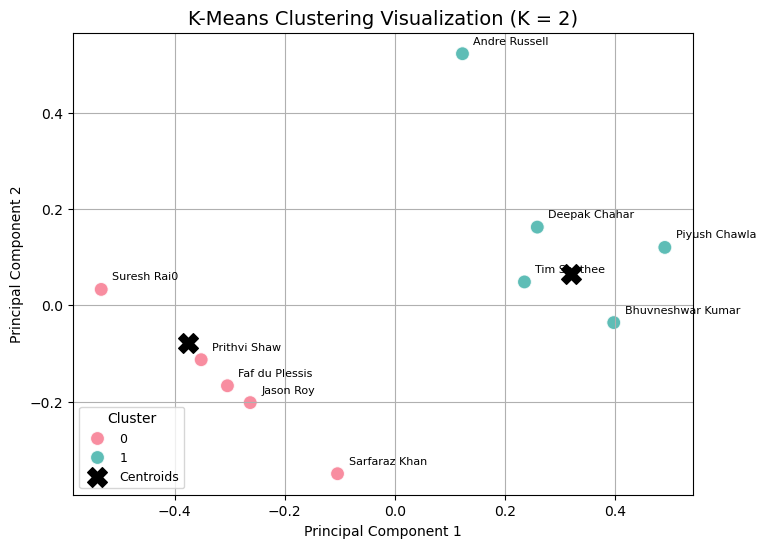

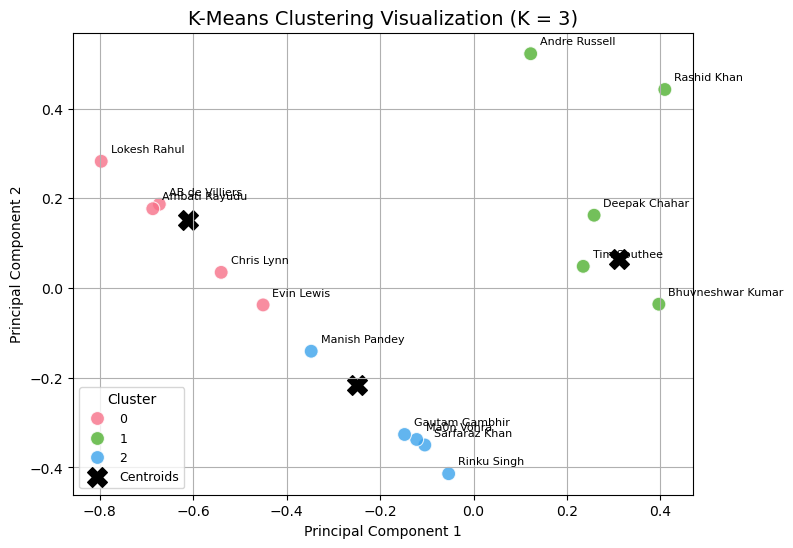

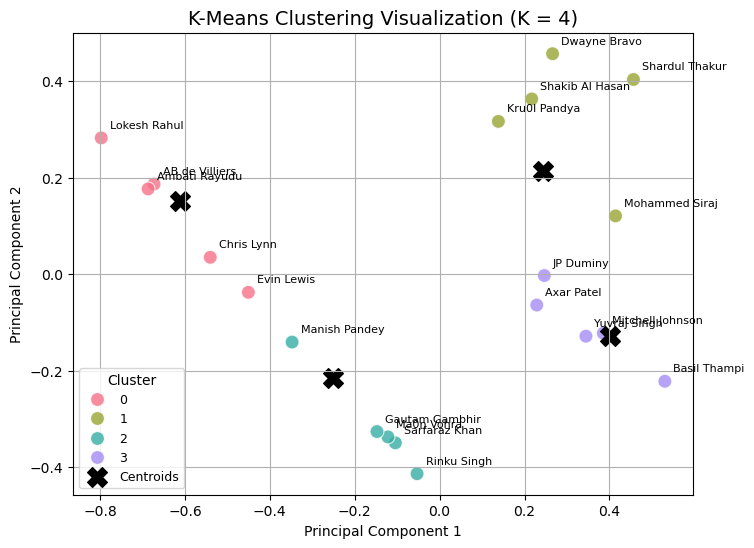

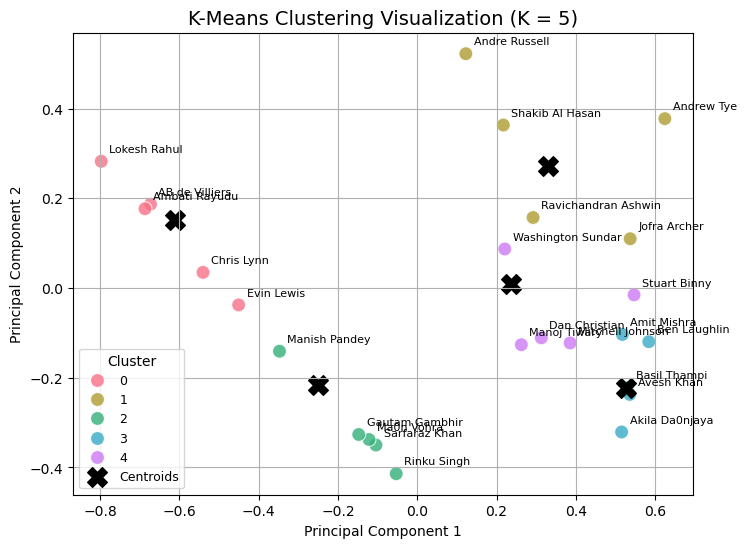

In [13]:
# ==============================================================
# SECTION 6: PCA VISUALIZATION AND CLUSTER PLOTS (Question c)
# ==============================================================

# Select normalized numerical features for PCA
features = ['runs_scored', 'average_runs', 'strike_rate', 'wickets_obtained', 'bowling_economy']
X = df_normalized[features].values

# Apply PCA to reduce to 2 components for 2D visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Add PCA-transformed coordinates to the normalized DataFrame
df_pca = df_normalized.copy()
df_pca['PCA1'] = X_pca[:, 0]
df_pca['PCA2'] = X_pca[:, 1]

# Define K values to visualize
k_values = [2, 3, 4, 5]

for k in k_values:
    # Run K-Means
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X)
    df_pca['Cluster'] = labels
    
    # Plot setup
    plt.figure(figsize=(8, 6))
    palette = sns.color_palette("husl", k)
    
    # For each cluster, select 5 random points to plot
    plot_df = pd.DataFrame(columns=df_pca.columns)
    for cluster_id in range(k):
        cluster_points = df_pca[df_pca['Cluster'] == cluster_id]
        sample_points = cluster_points.sample(min(5, len(cluster_points)), random_state=42)
        plot_df = pd.concat([plot_df, sample_points])
    
    # Scatter plot for sampled points
    sns.scatterplot(
        data=plot_df,
        x='PCA1', y='PCA2',
        hue='Cluster',
        palette=palette,
        s=100,
        alpha=0.8,
        legend='full'
    )
    
    # Plot cluster centers (transformed using PCA)
    centers_pca = pca.transform(kmeans.cluster_centers_)
    plt.scatter(centers_pca[:, 0], centers_pca[:, 1], 
                c='black', marker='X', s=200, label='Centroids')
    
    # Label all points (only 5 per cluster)
    for _, row in plot_df.iterrows():
        plt.text(row['PCA1']+0.02, row['PCA2']+0.02, row['PLAYER'], fontsize=8)
    
    # Titles and aesthetics
    plt.title(f'K-Means Clustering Visualization (K = {k})', fontsize=14)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='lower left', fontsize=9, title='Cluster')
    plt.grid(True)
    plt.show()


### K-Means Cluster Plots Interpretation

#### **K = 2**

* The data splits into **two major clusters**, separating players with generally **higher batting metrics** (runs, average, strike rate) from those with **higher bowling metrics** (wickets, economy).
* Cluster colors distinguish the two groups clearly.
* **Player labels** (5 per cluster) show representative players in each cluster.
* **Centroids** indicate the “center” of each cluster in terms of PCA-reduced performance metrics.

**Observation:** Two broad player categories appear: mainly batsmen vs mainly bowlers.

---

#### **K = 3**

* The data splits into **three clusters**, allowing more granularity:

  1. Batsmen with strong batting metrics.
  2. Bowlers with strong bowling metrics.
  3. All-rounders with a mix of batting and bowling performance.
* Cluster colors are distinct, and 5 labeled players per cluster help identify characteristic players.
* Centroids now highlight the three cluster centers.

**Observation:** Introducing K=3 captures an **all-rounder group**, making the clusters more meaningful.

---

#### **K = 4**

* With **four clusters**, players are further subdivided:

  * Top-performing batsmen (high runs and strike rate)
  * Average-performing batsmen
  * Strong bowlers (low economy, high wickets)
  * All-rounders (balanced metrics)
* The PCA 2D plot shows some overlap but clusters are mostly separable.
* Player labels show representative individuals in each cluster.

**Observation:** K=4 provides a finer separation of skill levels, especially among batsmen.

---

#### **K = 5**

* **Five clusters** capture even more nuanced distinctions:

  1. Elite batsmen
  2. Average batsmen
  3. Elite bowlers
  4. Average bowlers
  5. All-rounders
* Some cluster points are close together due to PCA reduction, but colors help distinguish clusters.
* Only 5 player names per cluster are labeled for clarity, showing examples from each category.

**Observation:** K=5 gives the **most detailed clustering**, but PCA 2D visualization may cause some clusters to appear closer than they actually are in high-dimensional space.

---

#### General Notes Across All Plots:

* **PCA reduces dimensionality** but preserves most variance, so cluster proximity in 2D approximates real similarities.
* **Centroids** provide reference points for cluster “average performance.”
* Labeling **5 players per cluster** balances clarity and completeness.
* As K increases, clusters become more granular, but overlap may appear in PCA visualization due to dimensionality reduction.



### Silhouette Score Visualization
#### d. Draw a bar graph with X-axis as K value and Y-axis as silhouette score. 

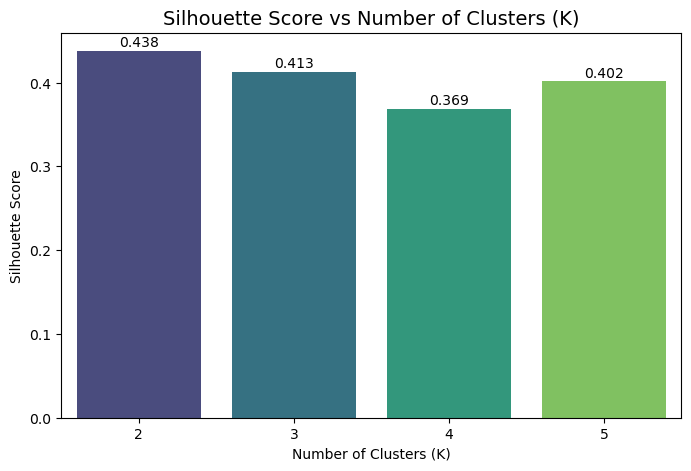

In [16]:
# ==============================================================
# SECTION 7: SILHOUETTE SCORE VISUALIZATION (Question d)
# ==============================================================

# -------------------- Task (d): Bar graph of Silhouette Score vs K --------------------

plt.figure(figsize=(8, 5))
sns.barplot(data=silhouette_df, x='K', y='Silhouette Score', palette='viridis')

# Add score annotations above bars
for index, row in silhouette_df.iterrows():
    plt.text(row['K'] - 1.87, row['Silhouette Score'] + 0.005, f"{row['Silhouette Score']:.3f}", 
             color='black', ha="right", fontsize=10)

plt.title('Silhouette Score vs Number of Clusters (K)', fontsize=14)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.show()


### Interpretation of Silhouette Score Bar Plot

- The bar plot shows silhouette scores for different values of K (2, 3, 4, 5).  
- Silhouette score measures how well-separated the clusters are (closer to 1 is better).  
- **Observations:**
  - **K = 2:** Highest silhouette score → clusters are most distinct and well-separated.  
  - **K = 3:** Slightly lower score → reasonable separation with an extra cluster (all-rounders).  
  - **K = 4 & 5:** Scores drop → clusters overlap more, indicating over-segmentation.  
- **Conclusion:** K = 2 is the most optimal choice based on cluster quality.


### Player categorization by clusters
#### e. List down 10  players with each cluster and categorize them to the batsman, all-rounder, bowler, etc. 

In [19]:
# ==============================================================
# SECTION 8: PLAYER CATEGORIZATION BY CLUSTERS (Question e)
# ==============================================================

# -------------------- Task (e): List 10 Players per Cluster and Categorize --------------------

# We'll use the best-performing K (based on highest Silhouette Score)
best_k = silhouette_df.loc[silhouette_df['Silhouette Score'].idxmax(), 'K']
print(f"Best K value based on Silhouette Score: {int(best_k)}")

# Run K-Means again with the best K
kmeans_final = KMeans(n_clusters=int(best_k), random_state=42)
labels_final = kmeans_final.fit_predict(df_normalized[features].values)

# Add cluster labels to the original dataset
df_clusters = df.copy()
df_clusters['Cluster'] = labels_final

# Define a simple rule-based categorization
def categorize_player(row):
    if row['wickets_obtained'] == 0:
        return 'Batsman'
    elif row['wickets_obtained'] > 0 and row['runs_scored'] < 100:
        return 'Bowler'
    elif row['wickets_obtained'] > 0 and row['runs_scored'] >= 100:
        return 'All-Rounder'
    else:
        return 'Unknown'

# Apply the categorization
df_clusters['Category'] = df_clusters.apply(categorize_player, axis=1)

# Display 10 players from each cluster
for cluster_id in range(int(best_k)):
    cluster_data = df_clusters[df_clusters['Cluster'] == cluster_id]
    print(f"\nCluster {cluster_id + 1} — Sample 10 Players:")
    display(cluster_data[['PLAYER', 'runs_scored', 'wickets_obtained', 'Category']].head(10))


Best K value based on Silhouette Score: 2

Cluster 1 — Sample 10 Players:


,PLAYER,runs_scored,wickets_obtained,Category
0,Aaron Finch,134,0,Batsman
1,AB de Villiers,480,0,Batsman
2,Abhishek Sharma,63,0,Batsman
3,Ajinkya Rahane,370,0,Batsman
4,Alex Hales,148,0,Batsman
5,Ambati Rayudu,602,0,Batsman
12,Brendon McCullum,127,0,Batsman
14,Chris Gayle,368,0,Batsman
15,Chris Lynn,491,0,Batsman
19,Colin Munro,63,0,Batsman



Cluster 2 — Sample 10 Players:


,PLAYER,runs_scored,wickets_obtained,Category
6,Andre Russell,316,13,All-Rounder
7,Andrew Tye,32,24,Bowler
8,Axar Patel,80,3,Bowler
9,Ben Cutting,96,2,Bowler
10,Ben Stokes,196,8,All-Rounder
11,Bhuvneshwar Kumar,13,9,Bowler
13,Carlos Brathwaite,75,5,Bowler
16,Chris Morris,46,3,Bowler
17,Chris Woakes,17,8,Bowler
18,Colin de Grandhomme,131,2,All-Rounder


### Interpretation and Conclusion

#### Based on Silhouette Score Analysis:
- The **optimal number of clusters (K)** was selected based on the **highest Silhouette score**.
- This value ensured the most distinct separation between player performance groups.

#### Cluster Interpretation:
- Each cluster represents a **group of players with similar performance characteristics**.
- Players with **high batting averages and low bowling activity** belong to the **Batsmen cluster(s)**.
- Players with **high bowling contributions and fewer runs** belong to the **Bowlers cluster(s)**.
- Players performing **well in both batting and bowling** fall into the **All-Rounders cluster**.

#### PCA Visualization Insights:
- The **2D PCA plots** show that **K = 2 or K = 3** provides the most interpretable clusters.
- At **K = 2**, players are clearly separated into batting- and bowling-oriented groups.
- At **K = 3**, an additional batting subgroup appears, adding more detail.
- For **K = 4 and K = 5**, clusters begin to overlap, suggesting **over-segmentation**.

#### Practical Use of Clustering:
- These clusters can help teams **identify role-specific players**:
  - **Batsmen** for top-order stability  
  - **Bowlers** for wicket-taking potential  
  - **All-rounders** for balance in team composition  
- Coaches and analysts can use these insights for **team selection, player comparison**, and **performance evaluation**.

### Final Conclusion:
- **K = 2** gives a **clean and simple** clustering — best for clear skill differentiation.  
- **K = 3** provides **more nuance**, especially among batting-oriented players.  
- Both are considered **good cluster choices** based on visualization and interpretability.  
- This demonstrates how **unsupervised learning (K-Means)** can effectively uncover performance patterns in cricket data.
